# Imports

In [15]:
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from sklearn.preprocessing import MinMaxScaler

TESTING = False

# Classe que representa uma MLP

Implementado de uma maneira vetorizada por mini batch. 

In [16]:
class MLP(): 
    def __init__(self, dimensions=[], momentum=0.9, classification=True, 
                 lr=0.1, testing=False, use_relu=False):
        self.lr = lr
        self.velocities = []
        self.momentum = momentum
        self.classification = classification
        
        # Initialize fully connected layers
        self.layers = []
        for idx, (input_dim, output_dim) in enumerate(dimensions, 1):
            self.layers.append(self.Linear(input_dim, output_dim))
            # For each linear layer, add a velocity term starting at 0
            self.velocities.append(np.zeros((input_dim, output_dim)))
            if idx != len(dimensions):
                if use_relu:
                    self.layers.append(self.ReLU())
                else:
                    self.layers.append(self.Sigmoid())
            else: # Last layer
                if self.classification:
                    self.layers.append(self.Softmax()) # for the last use softmax
            
        if classification:
            self.cost = self.CrossEntropy()
        else:
            self.cost = self.SquareLoss()
        
    class Sigmoid():
        def forward(self, x):
            # Cip the sigmoid to avoid overflow
            # See https://stackoverflow.com/questions/23128401/overflow-error-in-neural-networks-implementation
            clipped_x = np.clip(x, -500, 500)
            self.old_y = np.exp(clipped_x) / (1. + np.exp(clipped_x))
            return self.old_y

        def backward(self, grad):
            return self.old_y * (1. - self.old_y) * grad

    class Softmax():
        def forward(self,x):
            self.old_y = np.exp(x) / np.exp(x).sum(axis=1) [:,None]
            return self.old_y

        def backward(self,grad):
            return self.old_y * (grad -(grad * self.old_y).sum(axis=1)[:,None])

    class CrossEntropy():
        def forward(self,x,y):
            self.old_x = x.clip(min=1e-8,max=None)
            self.old_y = y
            return (np.where(y==1,-np.log(self.old_x), 0)).sum(axis=1)

        def backward(self):
            return np.where(self.old_y==1,-1/self.old_x, 0)
    
    class Linear():
        def __init__(self,n_in,n_out):
            self.weights = np.random.randn(n_in,n_out) * np.sqrt(2/n_in)
            self.biases = np.zeros(n_out)

            self.w_vel = np.zeros((n_in,n_out))
            self.b_vel = np.zeros(n_out)

        def update_velocity(self, w_vel, b_vel):
            self.w_vel = w_vel
            self.b_vel = b_vel

        def forward(self, x):
            self.old_x = x
            return np.dot(x,self.weights) + self.biases

        def backward(self,grad):
            self.grad_b = grad.mean(axis=0)
            self.grad_w = (np.matmul(self.old_x[:,:,None],grad[:,None,:])).mean(axis=0)
            return np.dot(grad,self.weights.transpose())

    def forward(self,x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def loss(self,x,y):
        return self.cost.forward(self.forward(x),y)

    def backward(self):
        grad = self.cost.backward()
        for i in range(len(self.layers)-1,-1,-1):
            grad = self.layers[i].backward(grad)
            
    def fit(self, x, y, n_iter=100, mini_batch=32):
        for _ in range(n_iter):   
            total_loss = 0
            for start_idx in range(0, len(x), mini_batch):
                x_batch = x[start_idx:start_idx+mini_batch]
                y_batch = y[start_idx:start_idx+mini_batch]   
                
                # Forward and backward
                loss = self.loss(x_batch,y_batch)
                total_loss += loss.sum()
                self.backward()
                
                # Update according to momentum
                for layer in self.layers:
                    if type(layer) == self.Linear:
                        new_w_vel = self.momentum*layer.w_vel - self.lr*layer.grad_w
                        new_b_vel = self.momentum*layer.b_vel - self.lr*layer.grad_b
                        
                        layer.weights += new_w_vel
                        layer.weights += new_b_vel
                        
                        layer.update_velocity(new_w_vel, new_b_vel)

    def predict(self, x):
        output = self.forward(x)
        if self.classification:
            return output.argmax(axis=-1)                       
        else:
            return output

# Classe que representa uma RBF

Implementado de uma maneira vetorizada por mini batch. 

Primeiro vamos definir as diversas funções de RBF:

In [105]:
def gaussian(X, centroid, sigma=None):
    norm = np.linalg.norm(X-centroid, axis=1)
    mult = -1 / (2*sigma**2)
    return np.exp(mult*norm**2)
    
def multi_square(X, centroid, sigma):
    norm = np.linalg.norm(X-centroid, axis=1)
    return np.sqrt(sigma**2 + norm**2)

def thin_plate_spline(X, centroid, sigma):
    norm = np.linalg.norm(X-centroid, axis=1)
    return norm*norm*np.log(norm[0])
    

Agora sim a nossa RBF que chama uma Adalaide simples por trás:

In [106]:
class RBF(): 
    def __init__(self, rbf, input_size=3, output_size=3, lr=0.1, 
                 testing=False):
        self.lr = lr
        self.mlp = MLP(dimensions=[(input_size, output_size)], momentum=0,
                      classification=True, lr=lr, testing=testing)
        
        # Initialize fully connected layers
        self.centroids = None
        self.rbf = rbf
           
    def calculate_sigma(self):
        """Calculate sigma according to:  sigma = Dmax / sqrt(2*K)
        where Dmax is the maximum dist between centroids and K the number of centroids
        """
        D_max = 0
        for idx, group1 in enumerate(self.centroids):
            for group2 in self.centroids[idx+1:]:
                dist = np.linalg.norm(group1-group2)
                if dist > D_max:
                    D_max = dist
        return D_max / np.sqrt(2*len(self.centroids))
        
    def rbf_layer(self, x):
        """Converts our x matrix, where each row is a example and each column a feature,
        into a new matrix where each row is a example and each columm a
        RBF function with a different centroid."""
        new_x = np.zeros((x.shape[0], len(self.centroids)))
        
        for idx, centroid in self.centroids.iterrows():
            new_x[:, idx-1] = self.rbf(x, centroid, self.sigma)
        return new_x

    def fit(self, x, y, n_iter=100, mini_batch=32):
        # Calculate the centroids and sigma
        self.centroids = x.groupby(y).mean()
        self.sigma = self.calculate_sigma()
        
        # Go through the RBF layer
        new_x = self.rbf_layer(x)
        new_y = pd.get_dummies(y).values
        
        # Call the 1 layer MLP
        self.mlp.fit(new_x, new_y, n_iter=n_iter)
                
    def predict(self, x):
        new_x = self.rbf_layer(x)
        output = self.mlp.forward(new_x)
        return output.argmax(axis=-1)                       



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Funções auxiliares

Diversas funções que seram utilizadas para ambos os datasets

Função para carregar os dados

In [107]:
def load_and_analyze(filename, target, header=0):
    df = pd.read_csv(filename, header=header)
    # Check for nulls
    print(f"Temos {df.isna().sum().sum()} nulos na nossa tabela")
    
    x = df.drop(columns=[target])
    y = df[target] - 1
    sns.countplot(y)
    plt.show()
    return x, y


Temos 0 nulos na nossa tabela


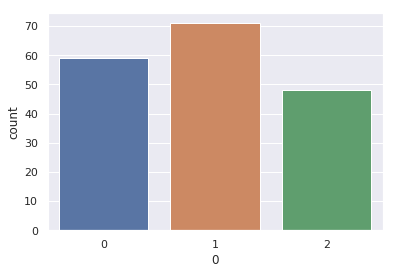

In [108]:
x, y = load_and_analyze("wine.data", target=0, header=None)

Função  para normalizar os dados que vamos utilizar posteriormente

In [109]:
def normalize_data(x_train, x_test, y=None, pandas=True):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
    x_train_norm, x_test_norm = [pd.DataFrame(x) for x in (x_train_norm, x_test_norm)]
    
    return x_train_norm, x_test_norm

Função para rodar 1 experimento

In [110]:
def run_experiment(x, y, model, test_percent=0.3, n_iter=100, mlp=False):
    start_time = time.time()
    
    # Process our data and normalize
    if mlp:
        new_y = pd.get_dummies(y)
    else:
        new_y = y
        
    x_train, x_test, y_train, y_test = train_test_split(x, new_y, stratify=y, 
                                                       test_size=test_percent)
    x_train, x_test = normalize_data(x_train, x_test, pandas=True)

    # Train and evaluate
    if mlp:
        model.fit(x_train.values, y_train.values, n_iter=n_iter)
    else:
        model.fit(x_train, y_train.values, n_iter=n_iter)
    preds = model.predict(x_test)
    
    if mlp:
        score = accuracy_score(y_test.values.argmax(axis=-1), preds)
    else:
        score = accuracy_score(y_test, preds)
    end_time = time.time()
    
    return score, end_time-start_time
    

Roda todos os nossos experimentos

In [127]:
cols = ["Nome", "Acurácia", "Tempo"]
results = pd.DataFrame(columns=cols)

models = {
    "RBF-G": RBF(gaussian),
    "RBF-MQ": RBF(multi_square),
    "RBF-TPS": RBF(thin_plate_spline),
    "MLP-0": MLP(dimensions=[(13, 3)], momentum=0, lr=0.1),
    "MLP-1": MLP(dimensions=[(13, 32), (32, 3)], momentum=0, lr=0.1),
    "MLP-2": MLP(dimensions=[(13, 16), (16, 8), (8, 3)], momentum=0, lr=0.1),
}
is_mlp = [False]*3 + [True]*3



In [ ]:
n_iter = 10000
for (name, model), mlp in zip(models.items(), is_mlp):
    score, runtime = run_experiment(x, y, model, n_iter=n_iter, mlp=mlp)
    results.loc[(len(results))] = (name, score, runtime)

In [ ]:
results

In [ ]:
# Format the data to be generated in our report, using https://www.tablesgenerator.com/
for index, data in results.iterrows():
    name, acc, runtime = data 
    print(f"{name}\t{100*acc:.2f}%\t{runtime:.2f}s")